In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import scipy.io as sci

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

from sklearn.model_selection import train_test_split
from functools import partial

### Files

In [2]:
colab = True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/'
else:
    path = './'

Mounted at /content/drive


In [3]:
Y_file = sci.loadmat(path + 'Y_clean.mat')
Y_clean = Y_file['Y_clean'].astype(float)

A_file = sci.loadmat(path + 'A_true.mat')
A_true = A_file['A_true']

E_file = sci.loadmat(path + 'E.mat')
E = E_file['E']

nCol, nRow = 95, 95
n, m = 96, 96
r_channels = 3
p = 156

### Images shapes

In [4]:
A_true.shape, E.shape, Y_clean.shape

((95, 95, 3), (156, 3), (95, 95, 156))

In [5]:
Y = np.zeros((n, m, p))
Y[:-1, :-1] = Y_clean
Y[-1, :], Y[:, -1] = 0, 0

A_gt = np.zeros((n, m, r_channels))
A_gt[:-1, :-1] = A_true
A_gt[-1, :], A_gt[:, -1] = 0, 0

Y.shape, A_gt.shape

((96, 96, 156), (96, 96, 3))

### Ground truth loss

In [6]:
output = torch.tensor(A_gt)
end_member_estimation = torch.tensor(E.T)
gt_fractional_abundance = torch.tensor(Y.reshape((-1, p)))
output.shape, end_member_estimation.shape, gt_fractional_abundance.shape

(torch.Size([96, 96, 3]), torch.Size([3, 156]), torch.Size([9216, 156]))

In [7]:
criterion = nn.MSELoss()
loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
loss

tensor(7.6716e-36, dtype=torch.float64)

### Abundances

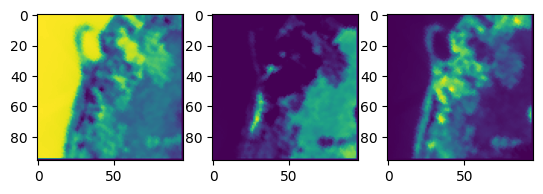

In [8]:
for i in range(3): 
    ax = plt.subplot(1, 3, i+1)
    ax.imshow(A_gt[:,:,i])

### Models

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [16,32,64,128]
decoder_channels = [128,64,32,r_channels]

# Define the network architecture
class Undip_net(nn.Module):
  def __init__(self):
    super(Undip_net, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), # (308,308)
                                  nn.MaxPool2d(1, stride=2, padding=0), # (154,154)
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
                                  nn.MaxPool2d(1, stride=2, padding=0), # (77,77)
    )
    
    self.encoder3 = nn.Sequential(nn.Conv2d(encoder_channels[1], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[2]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
                                  #nn.MaxPool2d(1, stride=2, padding=0),
    )
    
    
    self.encoder4 = nn.Sequential(nn.Conv2d(encoder_channels[2], encoder_channels[3], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[3]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
                                  #nn.MaxPool2d(1, stride=2, padding=0),
    )
    
    
    self.base_conv = nn.Sequential(nn.Conv2d(encoder_channels[3], decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                   nn.BatchNorm2d(decoder_channels[0]),
                                   nn.LeakyReLU(inplace=True), # (77,77)
    )
    
    self.decoder1 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )


    self.skip1 = nn.Sequential(nn.Conv2d(encoder_channels[2], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[2]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[2], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[2]),
                               nn.LeakyReLU(inplace=True),
    )
    
    self.decoder2 = nn.Sequential(nn.Conv2d(encoder_channels[2]+decoder_channels[0], decoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )

    self.skip2 = nn.Sequential(nn.Conv2d(encoder_channels[1], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[1]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[1], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[1]),
                               nn.LeakyReLU(inplace=True),
    )
    
    self.decoder3 = nn.Sequential(nn.ConvTranspose2d(encoder_channels[1]+decoder_channels[1], decoder_channels[2], (4, 4), stride=(2, 2), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[2]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
    )

    self.skip3 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[0]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[0], encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[0]),
                               nn.LeakyReLU(inplace=True)
    )
    
    self.decoder4 = nn.Sequential(nn.ConvTranspose2d(encoder_channels[0]+decoder_channels[2], decoder_channels[3], (4, 4), stride=(2, 2), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[3]),
                                  nn.Softmax(), # (307,307)
    )




  def forward(self, input):
    
    
    features = []
    
    current_feature = self.encoder1(input)
    features.append(current_feature)
    
    current_feature = self.encoder2(current_feature)
    features.append(current_feature)
    
    current_feature = self.encoder3(current_feature)
    features.append(current_feature)
    
    current_feature = self.encoder4(current_feature)
    #features.append(current_feature)
    
    current_feature = self.base_conv(current_feature)
    
    current_feature = self.decoder1(current_feature)
    
    features[2] = self.skip1(features[2])
    current_feature = torch.cat((current_feature,features[2]), dim=1)
    current_feature = self.decoder2(current_feature)
    
    features[1] = self.skip2(features[1])
    current_feature = torch.cat((current_feature,features[1]), dim=1)
    current_feature = self.decoder3(current_feature)

    features[0] = self.skip3(features[0])
    current_feature = torch.cat((current_feature,features[0]), dim=1)
    output = self.decoder4(current_feature)

      
      
    return output



def train(model, input, end_member_estimation, gt_fractional_abundance, epochs=1000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  model = model.to(device)
  criterion = criterion.to(device)


  
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input).double()
    loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    print('Epoch {}: '.format(epoch), loss.item())
    
    loss.backward()
    optimizer.step()


  return model



In [20]:
nn.Conv2d?

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [256,256]
decoder_channels = [256,256,r_channels]
skip_channels = 4

# Define the network architecture
class Undip_net_paper(nn.Module):
  def __init__(self):
    super(Undip_net_paper, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), 
                                            stride=(2, 2), padding=1, dilation=1), # (308,308) to (154,154)
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), 
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (154,154)
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')


    self.skip = nn.Sequential(nn.Conv2d(r_channels, skip_channels, (1, 1), stride=(1, 1), 
                                        padding=0, dilation=1),
                              nn.BatchNorm2d(skip_channels),
                              nn.LeakyReLU(inplace=True, negative_slope=0.1),
    )
    
    
    
    self.decoder1 = nn.Sequential(nn.BatchNorm2d(encoder_channels[1]+skip_channels),
                                  nn.Conv2d(encoder_channels[1]+skip_channels, decoder_channels[0],
                                            (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1)
    )


   
    self.decoder2 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (77,77)
    )

    self.decoder3 = nn.Sequential(nn.Conv2d(decoder_channels[1], decoder_channels[2], (3, 3), 
                                            stride=(1, 1), padding=1, dilation=1),
                                  nn.Softmax()
    )


  def forward(self, input):
    
        
    current_feature = self.encoder1(input)
    current_feature = self.encoder2(current_feature)
    current_feature = self.upsample(current_feature)
    
    current_skip_output = self.skip(input)

    current_feature = torch.cat((current_feature,current_skip_output), dim=1)
    
    
    current_feature = self.decoder1(current_feature)
    current_feature = self.decoder2(current_feature)
    output = self.decoder3(current_feature)
    
      
    return output



def train(model, input, end_member_estimation, gt_fractional_abundance, epochs=2000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  end_member_estimation = end_member_estimation.to(device)
  gt_fractional_abundance = gt_fractional_abundance.to(device)


  losses = []
  outputs = torch.zeros([epochs, 1, r_channels, n, m])
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input)
    loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    print('Epoch {}: '.format(epoch), loss.item())
    losses.append(loss.item())
    outputs[epoch-1] = output
    
    loss.backward()
    optimizer.step()

  return outputs, losses



### Training

In [22]:
A = torch.normal(0,1,size=(1,r_channels,n,m))
E_tensor = torch.tensor(E.T, dtype=torch.float32)
Y_tensor = torch.tensor(Y.reshape((-1, p)), dtype=torch.float32)

In [23]:
Undip_model = Undip_net_paper()
# the training command
outputs, losses = train(Undip_model,A, E_tensor, Y_tensor, lr=0.001, epochs=3000)

Epoch 1:  0.04214553162455559
Epoch 2:  0.05468327924609184
Epoch 3:  0.046404771506786346
Epoch 4:  0.03559565544128418
Epoch 5:  0.036425553262233734
Epoch 6:  0.03573932126164436
Epoch 7:  0.034234996885061264
Epoch 8:  0.03399631381034851
Epoch 9:  0.03376800939440727
Epoch 10:  0.03321455419063568
Epoch 11:  0.03289252519607544
Epoch 12:  0.03290221467614174
Epoch 13:  0.03278806433081627
Epoch 14:  0.032420814037323
Epoch 15:  0.03207952901721001
Epoch 16:  0.03194524720311165
Epoch 17:  0.03191661089658737
Epoch 18:  0.03183692321181297
Epoch 19:  0.031671106815338135
Epoch 20:  0.03147268295288086
Epoch 21:  0.031304243952035904
Epoch 22:  0.031194202601909637
Epoch 23:  0.031122174113988876
Epoch 24:  0.031038764864206314
Epoch 25:  0.030918309465050697
Epoch 26:  0.030785465613007545
Epoch 27:  0.030679263174533844
Epoch 28:  0.03060491941869259
Epoch 29:  0.03053545020520687
Epoch 30:  0.03044973313808441
Epoch 31:  0.0303544569760561
Epoch 32:  0.030267862603068352
Epoch 33

In [29]:
A_ = outputs[-1]

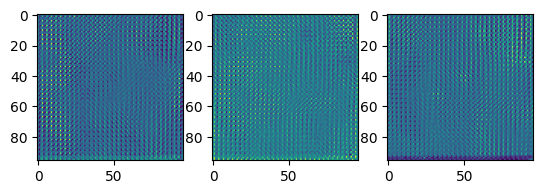

In [30]:
for i in range(3): 
    ax = plt.subplot(1, 3, i+1)
    im = A_.cpu().detach().numpy()
    im = im[0, i,:,:]
    ax.imshow(im)

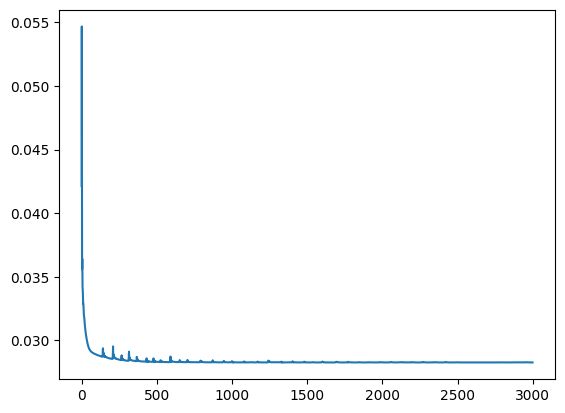

In [31]:
plt.plot(losses)

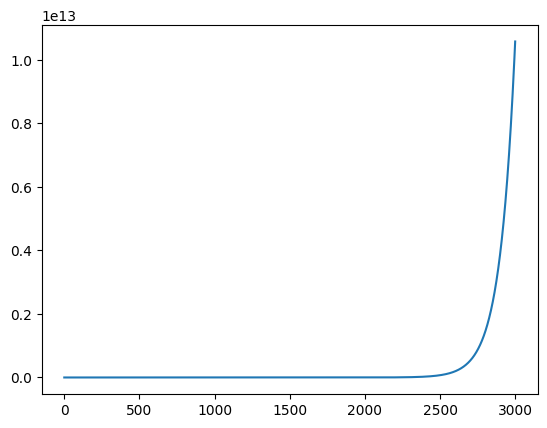

In [32]:
# Exponentially weighted average ?
weights = torch.exp(torch.arange(3000)/100)
plt.plot(weights)

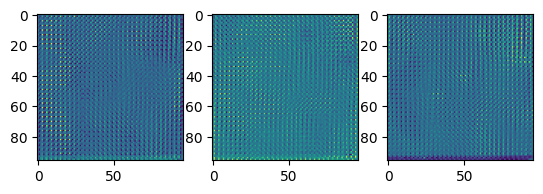

In [33]:
A_ = torch.mean(outputs*weights.view([3000, 1, 1, 1, 1]), dim=0)
A_ = A_/A_.max()

for i in range(3): 
      ax = plt.subplot(1, 3, i+1)
      im = A_.cpu().detach().numpy()
      im = im[0, i,:,:]
      ax.imshow(im)